
===== Test 1: Stable → Drift =====


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


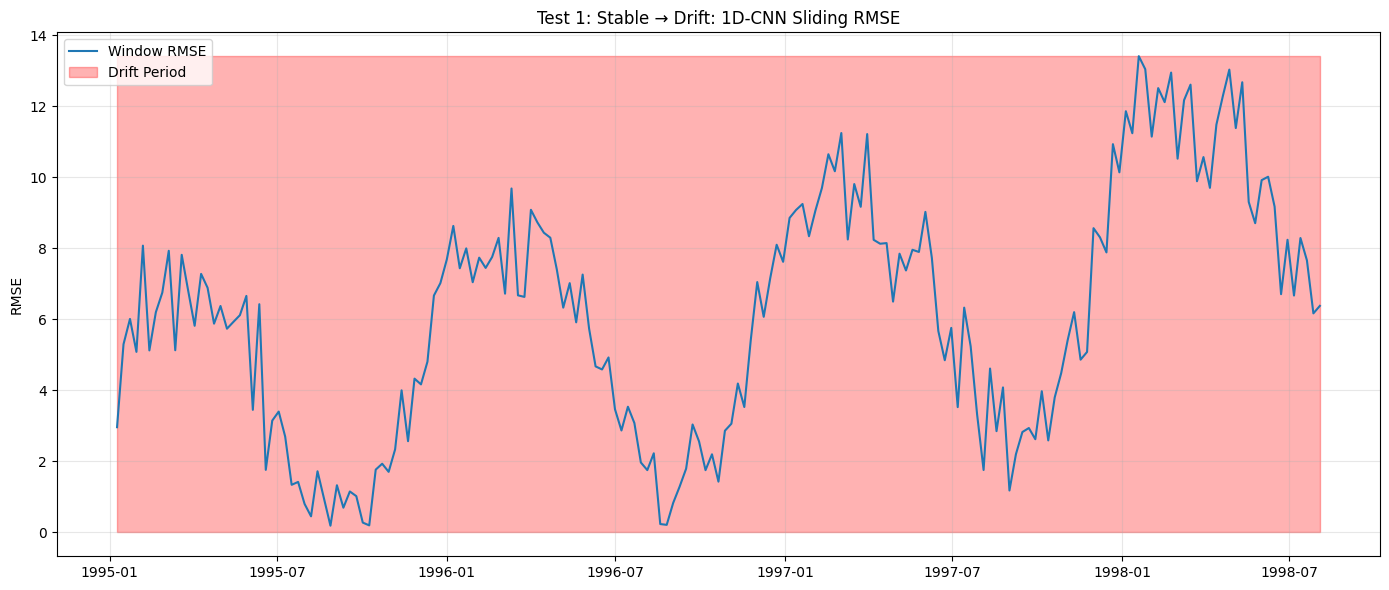

Stable RMSE: 1.980
Drift RMSE: 6.142
Robustness Ratio (Drift/Stable): 3.102

===== Test 2: Balanced Mix =====


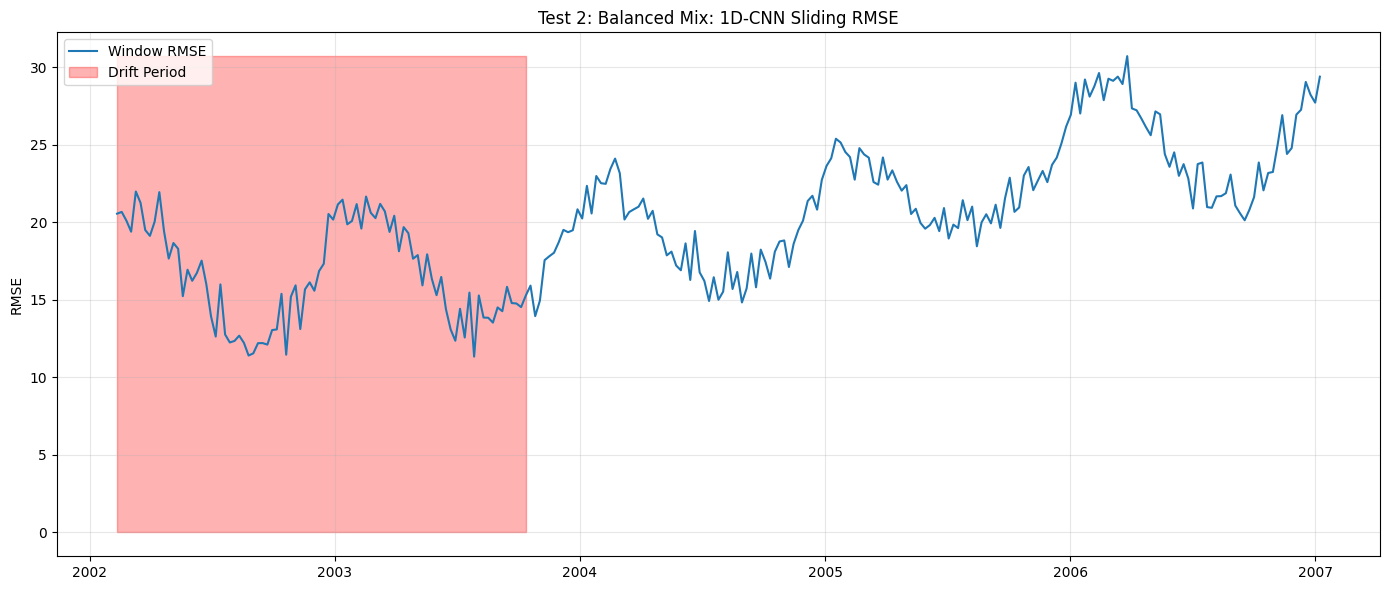

Stable RMSE: 21.905
Drift RMSE: 16.556
Robustness Ratio (Drift/Stable): 0.756

===== Test 3: Long Train, Short Inference =====


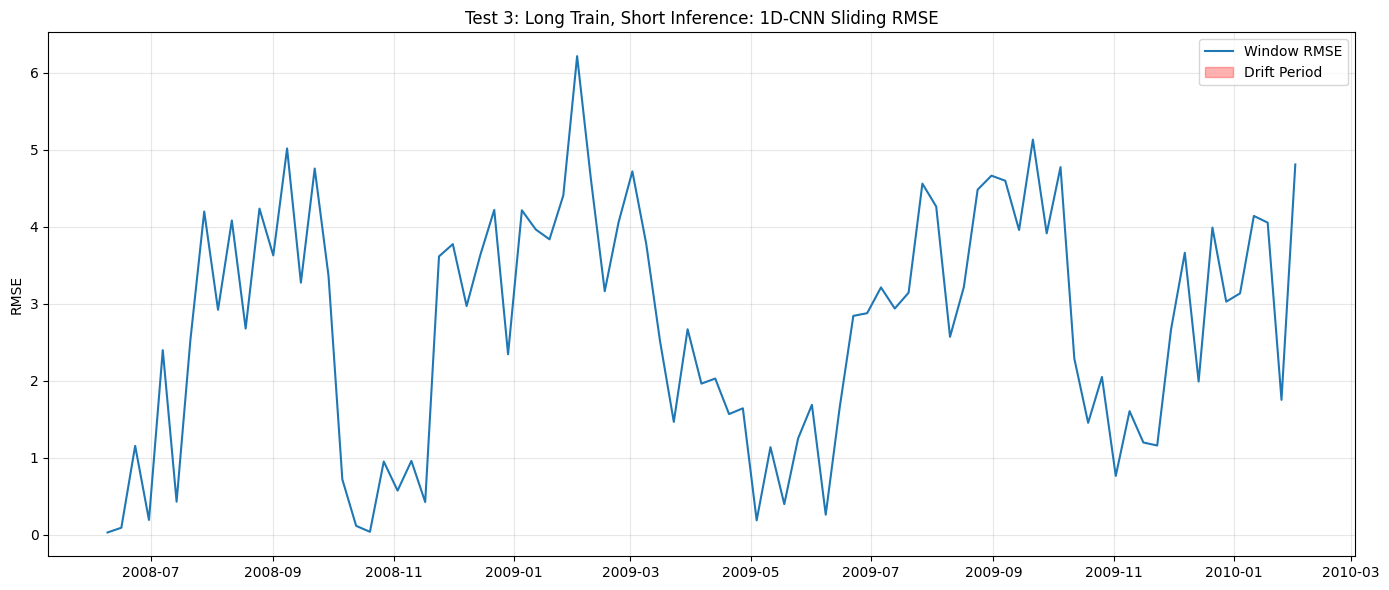

Stable RMSE: 2.731
Drift RMSE: nan
Robustness Ratio (Drift/Stable): nan

===== Test 4: Stable Only → Long Drift =====


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


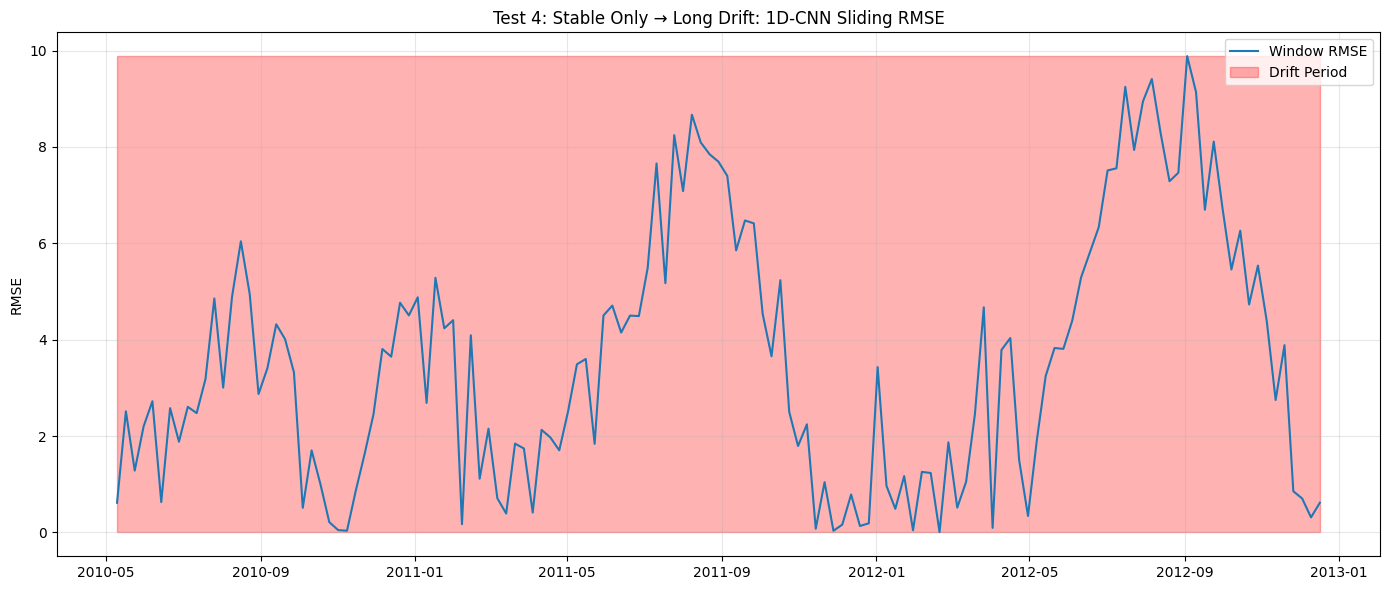

Stable RMSE: 5.552
Drift RMSE: 3.585
Robustness Ratio (Drift/Stable): 0.646

===== Test 5: Rolling Regimes =====


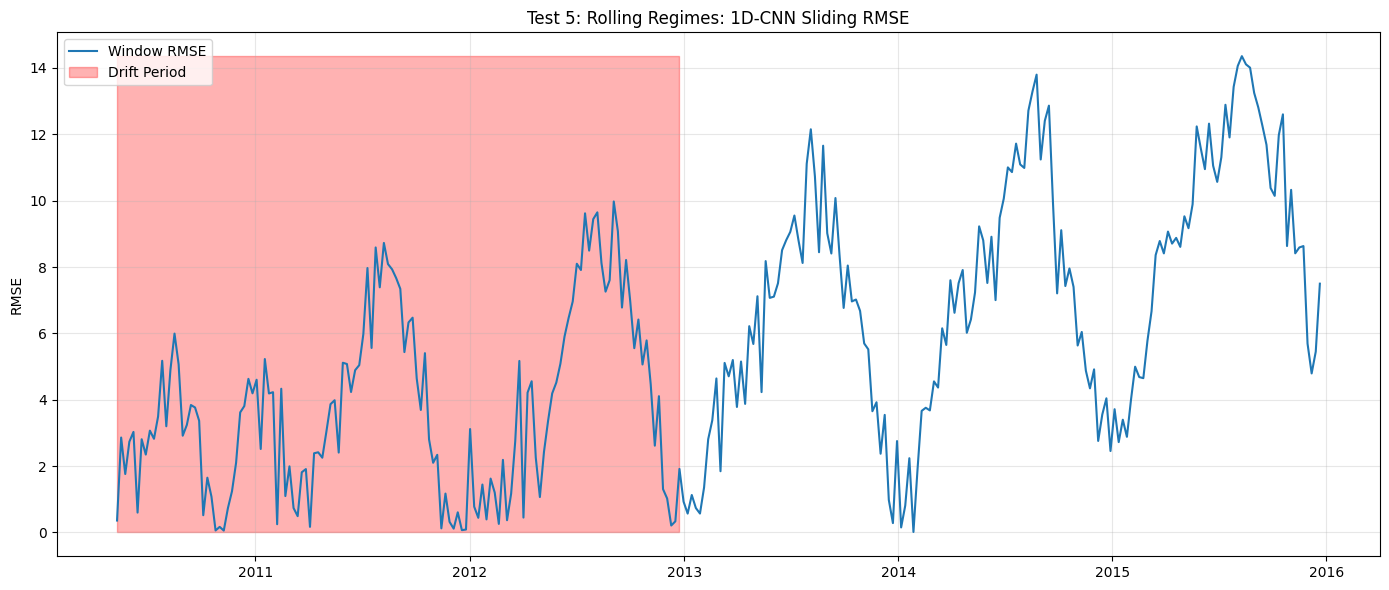

Stable RMSE: 7.330
Drift RMSE: 3.731
Robustness Ratio (Drift/Stable): 0.509


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# === Load Data ===
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

# === CNN Model ===
class CNN1DModel(nn.Module):
    def __init__(self, input_size, hidden_channels=32, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=hidden_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear((12 - kernel_size + 1) * hidden_channels, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, features, seq_len]
        x = self.relu(self.conv1(x))
        x = self.flatten(x)
        return self.fc(x).squeeze()

# === Utility ===
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

# === CNN Test Function with NaN Handling ===
def run_cnn_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    target = 'var1'
    features = [col for col in df.columns if col not in [target, 'drift_period']]

    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[features])
    y_all = df[target].values

    df['scaled_idx'] = np.arange(len(df))
    train_mask = (df.index >= train_start) & (df.index <= train_end)
    infer_mask = (df.index >= infer_start) & (df.index <= infer_end)

    train_indices = df[train_mask]['scaled_idx'].astype(int).values
    infer_indices = df[infer_mask]['scaled_idx'].astype(int).values

    SEQ_LEN = 12
    X_train = X_all[train_indices]
    y_train = y_all[train_indices]
    X_seq_train, y_seq_train = create_sequences(X_train, y_train, SEQ_LEN)

    model = CNN1DModel(input_size=X_seq_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        loss = criterion(model(X_seq_train), y_seq_train)
        loss.backward()
        optimizer.step()

    # === Inference ===
    results = []
    for idx in range(infer_indices[0], infer_indices[-1] - SEQ_LEN):
        x_seq = torch.tensor(X_all[idx:idx+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
        y_true = y_all[idx + SEQ_LEN]
        y_pred = model(x_seq).item()
        rmse = np.sqrt((y_pred - y_true) ** 2)
        drift_flag = int(df.iloc[idx + SEQ_LEN]['drift_period'] > 0.5)
        date = df.index[idx + SEQ_LEN]

        results.append({'date': date, 'rmse': rmse, 'is_drift': drift_flag})

    results_df = pd.DataFrame(results).set_index('date')

    # === Aggregate Metrics ===
    mean_rmse_drift = results_df[results_df['is_drift'] == 1]['rmse'].mean()
    mean_rmse_stable = results_df[results_df['is_drift'] == 0]['rmse'].mean()

    # Fallback to RMSE from training if category missing
    if np.isnan(mean_rmse_stable):
        fallback = df.iloc[train_indices[:SEQ_LEN * 2]]
        stable_subset = fallback[fallback['drift_period'] == 0]
        if len(stable_subset) >= SEQ_LEN:
            y_pred = model(torch.tensor(scaler.transform(stable_subset[features].values[-SEQ_LEN:]).reshape(1, SEQ_LEN, -1), dtype=torch.float32)).item()
            y_true = stable_subset[target].values[-1]
            mean_rmse_stable = np.sqrt((y_pred - y_true) ** 2)

    if np.isnan(mean_rmse_drift):
        fallback = df.iloc[train_indices[:SEQ_LEN * 2]]
        drift_subset = fallback[fallback['drift_period'] == 1]
        if len(drift_subset) >= SEQ_LEN:
            y_pred = model(torch.tensor(scaler.transform(drift_subset[features].values[-SEQ_LEN:]).reshape(1, SEQ_LEN, -1), dtype=torch.float32)).item()
            y_true = drift_subset[target].values[-1]
            mean_rmse_drift = np.sqrt((y_pred - y_true) ** 2)

    robustness_ratio = mean_rmse_drift / mean_rmse_stable if mean_rmse_stable > 0 else float('nan')

    # === Plot ===
    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Period')
    plt.title(f'{test_name}: 1D-CNN Sliding RMSE')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Stable RMSE: {mean_rmse_stable:.3f}")
    print(f"Drift RMSE: {mean_rmse_drift:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")
    
    # === Run 5 Test Cases ===
run_cnn_test("Test 1: Stable → Drift",
             "1990-01-01", "1994-10-10",         # stable block 1
             "1994-10-17", "1998-08-10")         # drift block 1

run_cnn_test("Test 2: Balanced Mix",
             "1994-10-17", "2001-11-12",         # drift block 1 + stable block 2
             "2001-11-19", "2007-01-15")         # drift block 2 + stable block 3

run_cnn_test("Test 3: Long Train, Short Inference",
             "1990-01-01", "2008-03-10",         # all data until end of drift block 3
             "2008-03-17", "2010-02-08")         # stable block 4

run_cnn_test("Test 4: Stable Only → Long Drift",
             "1990-01-01", "2010-02-08",         # all stable blocks up to stable block 4
             "2010-02-15", "2012-12-24")         # drift block 4

run_cnn_test("Test 5: Rolling Regimes",
             "1990-01-01", "2010-02-08",         # mixed training
             "2010-02-15", "2015-12-28")         # drift block 4 + stable block 5

